## DuckDB Kütüphanesi üzerinden SQL Kullanımına Yönelik Capstone Proje   

### 1. Veri Setinin İndirilmesi Yüklenmesi

In [1]:
pip install numpy pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install duckdb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import duckdb

conn = duckdb.connect(':memory:')

In [5]:
conn.execute("""
CREATE TABLE cars AS SELECT * FROM 'car_sales_dataset_with_person_details.csv';
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### 2. Veri incelemesi ve İlk SQL Sorgusu

In [7]:
result = conn.execute("DESCRIBE cars").fetchdf()

print(result)

   column_name column_type null   key default extra
0        Brand     VARCHAR  YES  None    None  None
1        Model     VARCHAR  YES  None    None  None
2         Year      BIGINT  YES  None    None  None
3        Price      DOUBLE  YES  None    None  None
4      Mileage      BIGINT  YES  None    None  None
5        Color     VARCHAR  YES  None    None  None
6    Condition     VARCHAR  YES  None    None  None
7   First Name     VARCHAR  YES  None    None  None
8    Last Name     VARCHAR  YES  None    None  None
9      Address     VARCHAR  YES  None    None  None
10     Country     VARCHAR  YES  None    None  None


In [8]:
conn.execute("""
SELECT * FROM read_csv_auto('car_sales_dataset_with_person_details.csv') LIMIT 5;
""").fetchdf()

,Brand,Model,Year,Price,Mileage,Color,Condition,First Name,Last Name,Address,Country
0,Honda,Civic,2023,25627.20,58513,Green,Certified Pre-Owned,Emily,Harris,456 Oak Ave,Brazil
1,Mazda,Mazda3,2000,12027.14,60990,Brown,Certified Pre-Owned,John,Harris,101 Maple Dr,Italy
2,Mazda,CX-5,2014,49194.93,1703,Green,Certified Pre-Owned,Karen,Wilson,202 Birch Blvd,UK
3,Hyundai,Tucson,2003,11955.94,25353,Silver,Used,Susan,Martinez,123 Main St,Mexico
4,Land Rover,Range Rover,2012,10910.01,76854,Orange,Used,Charles,Miller,456 Oak Ave,USA


### 3. Veri Temizliği ve Düzenlenmesi 

#### a. Eksik veri tespiti: 

In [9]:
result = conn.execute("""SELECT COUNT(*) AS Eksik_Veri_Sayısı FROM cars
                        WHERE   Brand IS NULL OR 
                                Model IS NULL OR 
                                Year IS NULL OR 
                                Price IS NULL OR 
                                Mileage IS NULL OR 
                                Color IS NULL OR 
                                Condition IS NULL OR 
                                "First Name" IS NULL OR 
                                "Last Name" IS NULL OR 
                                Address IS NULL OR 
                                Country IS NULL""").fetchdf()

print(result)

   Eksik_Veri_Sayısı
0                  0


#### b. Hatalı ve tutarsız veri tespiti:

In [10]:
result = conn.execute("""SELECT * FROM cars
                        WHERE Year < 1900 OR 
                              Year > 2025 OR
                              Price < 0 OR 
                              Mileage < 0 """).fetchdf()

print(result)

Empty DataFrame
Columns: [Brand, Model, Year, Price, Mileage, Color, Condition, First Name, Last Name, Address, Country]
Index: []


#### c. Veri temizliği işlemleri: 

##### NULL değerlerini doldurma:

In [11]:
# Eksik veri olsaydı ortalama değer ile doldurulması 
result = conn.execute("""UPDATE cars
                         SET Price = 
                                    (SELECT 
                                        AVG(Price) 
                                    FROM cars 
                                    WHERE Price IS NOT NULL)
                         WHERE Price IS NULL 
                         RETURNING *
                    """).fetchdf()

print(result)

Empty DataFrame
Columns: [Brand, Model, Year, Price, Mileage, Color, Condition, First Name, Last Name, Address, Country]
Index: []


In [14]:
# Eksik veri olsaydı en sık tekrar eden değer ile doldurulması 
result = conn.execute("""UPDATE cars
                         SET Year = 
                                    (SELECT Year
                                     FROM cars
                                     GROUP BY Year
                                     ORDER BY COUNT(*) DESC
                                     LIMIT 1)
                         WHERE Price IS NULL 
                         RETURNING *
                    """).fetchdf()

print(result)

Empty DataFrame
Columns: [Brand, Model, Year, Price, Mileage, Color, Condition, Country]
Index: []


##### Gereksiz sütunların silinmesi:

In [17]:
result = conn.execute("""ALTER TABLE cars DROP COlUMN "First Name";
                         ALTER TABLE cars DROP COLUMN "Last Name";
                         ALTER TABLE cars DROP COLUMN Address;
                    """).fetchdf()

# print(result)

BinderException: Binder Error: Table "cars" does not have a column with name "First Name"

Did you mean: "Brand"

In [16]:
conn.execute("DESCRIBE cars").fetchdf()

,column_name,column_type,null,key,default,extra
0,Brand,VARCHAR,YES,None,None,None
1,Model,VARCHAR,YES,None,None,None
2,Year,BIGINT,YES,None,None,None
3,Price,DOUBLE,YES,None,None,None
4,Mileage,BIGINT,YES,None,None,None
5,Color,VARCHAR,YES,None,None,None
6,Condition,VARCHAR,YES,None,None,None
7,Country,VARCHAR,YES,None,None,None


##### Veri türü dönüşümü

In [21]:
result = conn.execute("""ALTER TABLE cars
                         ALTER COLUMN Year TYPE DATE
                         USING STRPTIME(CAST(Year AS VARCHAR) || '-01-01', '%Y-%m-%d')
                    """).fetchdf()

print(result)

Empty DataFrame
Columns: [Success]
Index: []


In [22]:
conn.execute("SELECT Year FROM cars LIMIT 5").fetchdf()

,Year
0,2023-01-01
1,2000-01-01
2,2014-01-01
3,2003-01-01
4,2012-01-01


In [23]:
result = conn.execute("DESCRIBE cars").fetchdf()

print(result[result['column_name'] == 'Year'])

  column_name column_type null   key default extra
2        Year        DATE  YES  None    None  None


### 4. Temel İstatistiksel Analizler

##### Temel istatistiksel ölçümler

In [24]:
# Ortalama, maximum ve minimum araç fiyatları
conn.execute("SELECT AVG(Price), MAX(Price), MIN(Price) FROM cars").fetchdf()

,avg(Price),max(Price),min(Price)
0,42499.465158,79999.96,5000.06


In [25]:
# Medyan araç fiyatı
conn.execute("""SELECT percentile_cont(0.5) 
                WITHIN GROUP (ORDER BY Price) AS median_price
                FROM cars
             """).fetchdf()

,median_price
0,42504.71


In [27]:
# Araçların mil ölçümlerinin medyan değeri
conn.execute("""SELECT percentile_cont(0.5) 
                WITHIN GROUP (ORDER BY Mileage) AS median_mileage
                FROM cars
             """).fetchdf()

,median_mileage
0,99903.0


In [28]:
# En yeni ve en eski araç yılları
conn.execute("SELECT MAX(Year), MIN(Year) FROM cars").fetchdf()

,"max(""Year"")","min(""Year"")"
0,2024-01-01,2000-01-01


In [29]:
# En eski araç yaşı
conn.execute("SELECT (NOW()::date - MIN(Year)) // 365 AS En_Eski_Aracın_Yaşı FROM cars").fetchdf()

,En_Eski_Aracın_Yaşı
0,25


In [30]:
# En yeni araç yaşı
conn.execute("SELECT (NOW()::date - MAX(Year)) // 365 AS En_Yeni_Aracın_Yaşı FROM cars").fetchdf()

,En_Yeni_Aracın_Yaşı
0,1


##### Gruplama ve kategorik analiz

In [31]:
# Markaya göre ortalama, maximum ve minimum araç fiyatları
conn.execute("""SELECT
                Brand, 
                AVG(Price) AS Ort_Fiyat, 
                MAX(Price) AS Max_Fiyat, 
                MIN(Price) AS Min_Fiyat 
                FROM cars
                GROUP BY Brand
                ORDER BY AVG(Price) DESC
                """).fetchdf()

,Brand,Ort_Fiyat,Max_Fiyat,Min_Fiyat
0,Chrysler,42656.420811,79998.04,5000.39
1,Volkswagen,42632.434999,79999.40,5000.34
2,Nissan,42629.905228,79999.96,5002.59
3,Honda,42617.717830,79999.48,5000.06
4,Subaru,42602.340905,79999.78,5003.32
5,Dodge,42588.326027,79999.77,5000.11
6,Ford,42532.162015,79996.65,5002.12
7,Chevrolet,42527.995534,79999.59,5001.58
8,Hyundai,42491.646898,79997.75,5002.05
9,Toyota,42476.420307,79999.73,5000.43


In [32]:
# Modele göre ortalama, maximum ve minimum araç fiyatları
conn.execute("""SELECT
                Model, 
                AVG(Price) AS Ort_Fiyat, 
                MAX(Price) AS Max_Fiyat, 
                MIN(Price) AS Min_Fiyat 
                FROM cars
                GROUP BY Model
                ORDER BY AVG(Price) DESC
                """).fetchdf()

,Model,Ort_Fiyat,Max_Fiyat,Min_Fiyat
0,Pacifica,42954.515654,79998.04,5002.23
1,Journey,42939.570411,79997.54,5002.69
2,Passat,42846.646659,79999.40,5001.73
3,Civic,42835.807533,79998.06,5002.58
4,CX-5,42831.236857,79994.02,5009.72
...,...,...,...,...
83,Grand Cherokee,42171.100703,79992.54,5001.88
84,Velar,42166.967485,79998.11,5006.21
85,Z4,42128.901542,79998.86,5009.99
86,NX,42086.284014,79999.77,5012.35


In [31]:
# Color ve Condition durumlarına göre ortalama araç fiyatları
conn.execute("""SELECT
                Color,
                Condition, 
                AVG(Price) AS Ort_Fiyat, 
                FROM cars
                GROUP BY Color, Condition
                ORDER BY AVG(Price) DESC
                """).fetchdf()

,Color,Condition,Ort_Fiyat
0,Gray,New,42815.020201
1,Yellow,Certified Pre-Owned,42726.713048
2,Orange,Used,42717.328727
3,Blue,Used,42669.756993
4,Brown,Certified Pre-Owned,42659.682555
5,Silver,New,42599.134218
6,Green,New,42585.551421
7,White,New,42568.589609
8,White,Used,42554.931938
9,Silver,Used,42517.986163


In [33]:
# Ülkelere göre ortalama, maximum ve minimum araç fiyatları
conn.execute("""SELECT
                Country, 
                AVG(Price) AS Ort_Fiyat, 
                MAX(Price) AS Max_Fiyat, 
                MIN(Price) AS Min_Fiyat 
                FROM cars
                GROUP BY Country
                ORDER BY AVG(Price) DESC
                """).fetchdf()

,Country,Ort_Fiyat,Max_Fiyat,Min_Fiyat
0,Brazil,42634.248466,79999.77,5003.06
1,UK,42582.847099,79999.71,5001.02
2,Japan,42507.956761,79998.27,5000.34
3,Italy,42504.586079,79999.73,5000.39
4,Germany,42480.876639,79999.78,5000.43
5,Canada,42476.013089,79999.96,5000.92
6,USA,42473.539299,79999.94,5000.11
7,Australia,42467.808421,79999.87,5001.37
8,Mexico,42435.290505,79998.86,5000.06
9,France,42431.342308,79996.71,5002.05


##### Zaman Serisi ve Trend Analizleri 

In [34]:
# Üretim yıllarına göre ortlama araç fiyatlarının değişimi nasıl?
df_avg_price = conn.execute("""SELECT
                EXTRACT(YEAR FROM Year) AS Üretim_Yılı, 
                AVG(Price) AS Ort_Fiyat
                FROM cars
                GROUP BY Year
                ORDER BY AVG(Price) DESC
                """).fetchdf()
df_avg_price

,Üretim_Yılı,Ort_Fiyat
0,2011,42708.736200
1,2023,42630.217140
2,2021,42609.311260
3,2024,42598.671893
4,2017,42592.731889
5,2014,42583.395422
6,2008,42581.029480
7,2022,42571.094621
8,2002,42537.395414
9,2003,42519.206497


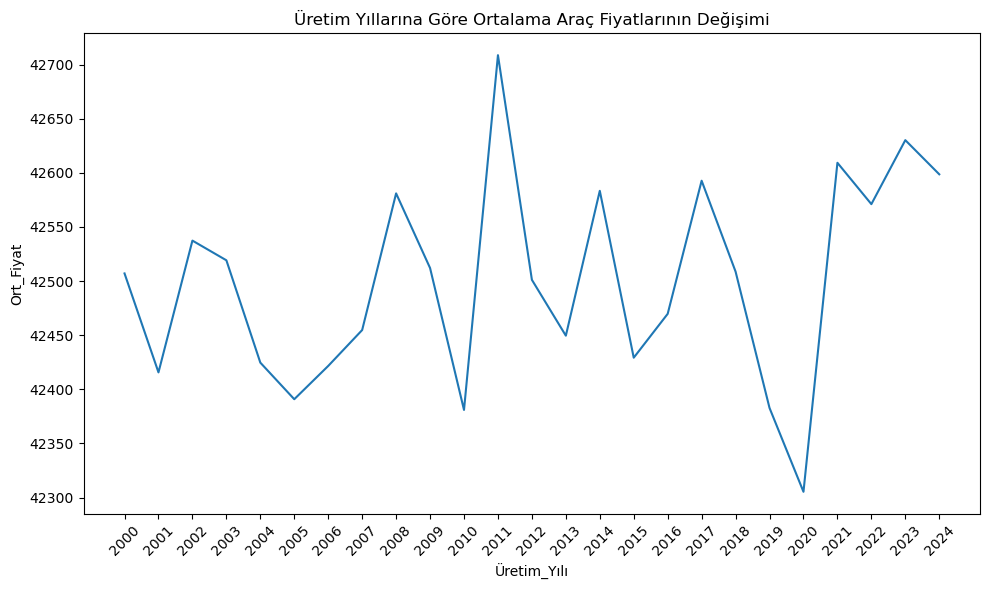

In [44]:
# Özellikle 2020-12 yılları arasında üretilen araçların ortalama fiyatının diğer yıllara göre yüksek olduğu görülmektedir.

plt.figure(figsize=(10,6))
sns.lineplot(x= 'Üretim_Yılı', y='Ort_Fiyat', data= df_avg_price)
plt.xticks(ticks=df_avg_price['Üretim_Yılı'].unique(), rotation=45)
plt.title("Üretim Yıllarına Göre Ortalama Araç Fiyatlarının Değişimi")
plt.tight_layout()
plt.show()

In [36]:
# Üretim yıllarına göre satılan araç sayısı durumu nasıl?
df_cars_sold = conn.execute("""SELECT
                EXTRACT(YEAR FROM Year) AS Üretim_Yılı, 
                COUNT(*) AS Satılan_Araç_Sayısı
                FROM cars
                GROUP BY Year
                ORDER BY Year
                """).fetchdf()
df_cars_sold

,Üretim_Yılı,Satılan_Araç_Sayısı
0,2000,39988
1,2001,40132
2,2002,40278
3,2003,40263
4,2004,40011
5,2005,39990
6,2006,39742
7,2007,40034
8,2008,39741
9,2009,39765


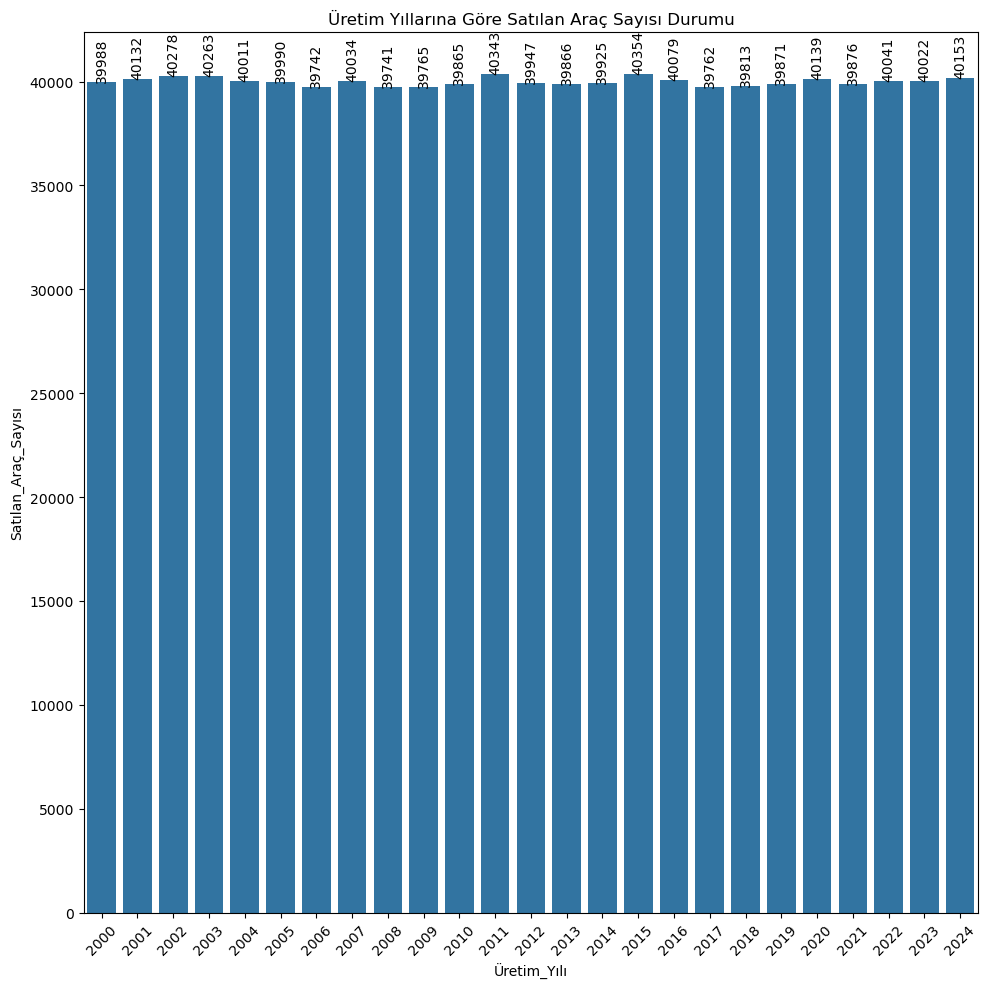

In [40]:
# Üretim yıllarına göre satılan araç sayısı durumunun birbirine yakın olduğu görülmektedir.

plt.figure(figsize=(10,10))
ax = sns.barplot(x= 'Üretim_Yılı', y='Satılan_Araç_Sayısı', data= df_cars_sold)
plt.xticks(rotation=45)
plt.title("Üretim Yıllarına Göre Satılan Araç Sayısı Durumu")

for container in ax.containers:
    ax.bar_label(container, rotation=90)

plt.tight_layout()
plt.show()

In [41]:
# Araçların üretim yıllarına göre toplam satış toplamlarının dağılımı:
df_total_sell = conn.execute("""SELECT
                EXTRACT(YEAR FROM Year) AS Üretim_Yılı, 
                SUM(Price) AS Satış_Toplamı
                FROM cars
                GROUP BY Year
                ORDER BY SUM(Price) DESC
                """).fetchdf()
df_total_sell

,Üretim_Yılı,Satış_Toplamı
0,2011,1.722999e+09
1,2002,1.713321e+09
2,2015,1.712188e+09
3,2003,1.711951e+09
4,2024,1.710464e+09
5,2023,1.706147e+09
6,2022,1.704589e+09
7,2001,1.702224e+09
8,2016,1.702144e+09
9,2014,1.700142e+09


<Figure size 1000x600 with 0 Axes>

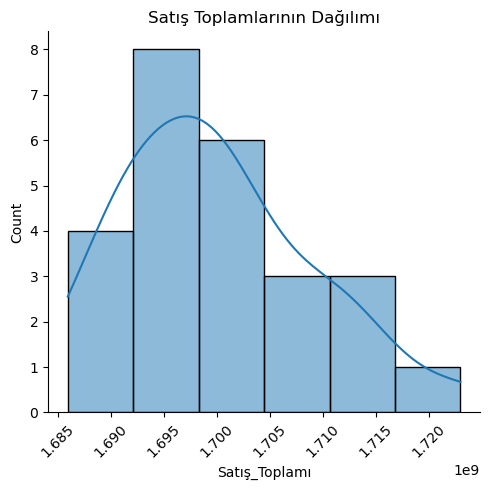

In [125]:
# Araçların yıllara göre satış toplamlarının dağılımının 1,7e+09 etrafında yoğunlaştığı görülmektedir.

plt.figure(figsize=(10,6))
sns.displot(x="Satış_Toplamı", data=df_total_sell, palette="tab10", kde = True)
plt.xticks(rotation=45)
plt.title("Satış Toplamlarının Dağılımı")
plt.tight_layout()
plt.show()

In [89]:
# Araçların üretim yıllarına göre ortalama kilometre (mileage) değişimi:
df_avg_mileage = conn.execute("""SELECT
                EXTRACT(YEAR FROM Year) AS Üretim_Yılı, 
                AVG(Mileage) AS Ort_Kilometre
                FROM cars
                GROUP BY Year
                ORDER BY Year
                """).fetchdf()
df_avg_mileage

,Üretim_Yılı,Ort_Kilometre
0,2000,99754.509453
1,2001,99895.376981
2,2002,99950.910025
3,2003,99780.205449
4,2004,99481.964160
5,2005,100387.030083
6,2006,100310.904157
7,2007,100185.249563
8,2008,99933.708865
9,2009,99662.199422


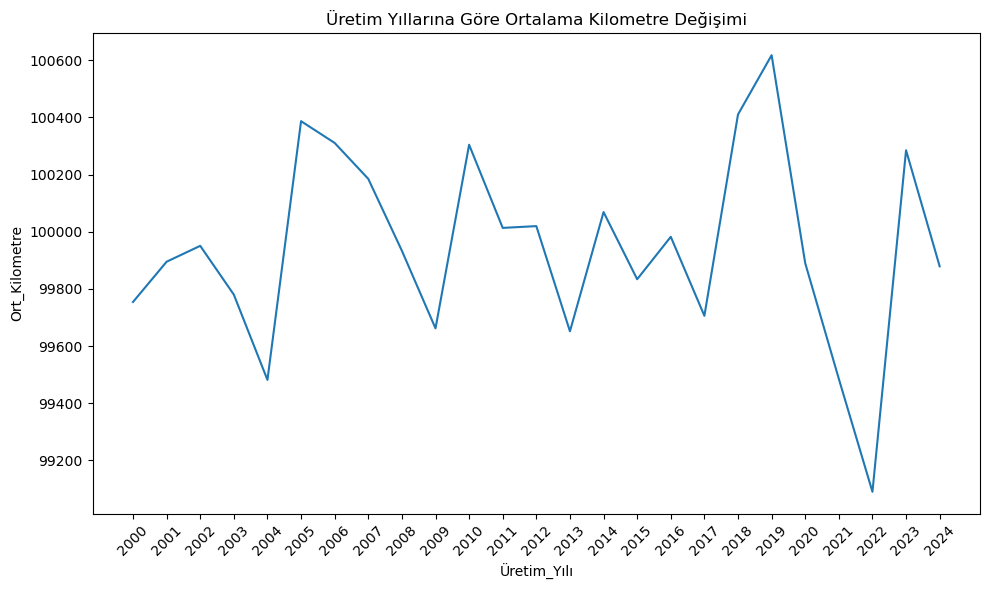

In [131]:
# Ortalama kilometre değişimlerinin 2018-2020 yıllarında en yüksek, 2021-2023 yılları arasında en düşük seviyede olduğu görülmektedir.

plt.figure(figsize=(10,6))
sns.lineplot(x= 'Üretim_Yılı', y='Ort_Kilometre', data= df_avg_mileage)
plt.xticks(ticks=df_avg_mileage['Üretim_Yılı'].unique(), rotation=45)
plt.title("Üretim Yıllarına Göre Ortalama Kilometre Değişimi")
plt.tight_layout()
plt.show()

In [91]:
# Araçların üretim yıllarına ve “Condition” (örn. Yeni / İkinci El) durumuna göre en çok satılan 20 araç.
df_condition = conn.execute("""SELECT
                EXTRACT(YEAR FROM Year) AS Üretim_Yılı,
                Condition,
                COUNT(Condition) AS Satılan_Araç
                FROM cars
                GROUP BY Year, Condition
                ORDER BY COUNT(Condition) DESC
                LIMIT 20
                """).fetchdf()
df_condition

,Üretim_Yılı,Condition,Satılan_Araç
0,2016,Used,13665
1,2024,New,13646
2,2015,Certified Pre-Owned,13636
3,2023,Certified Pre-Owned,13538
4,2011,Certified Pre-Owned,13523
5,2019,Certified Pre-Owned,13512
6,2002,Used,13493
7,2003,Certified Pre-Owned,13490
8,2020,Certified Pre-Owned,13483
9,2001,Used,13466


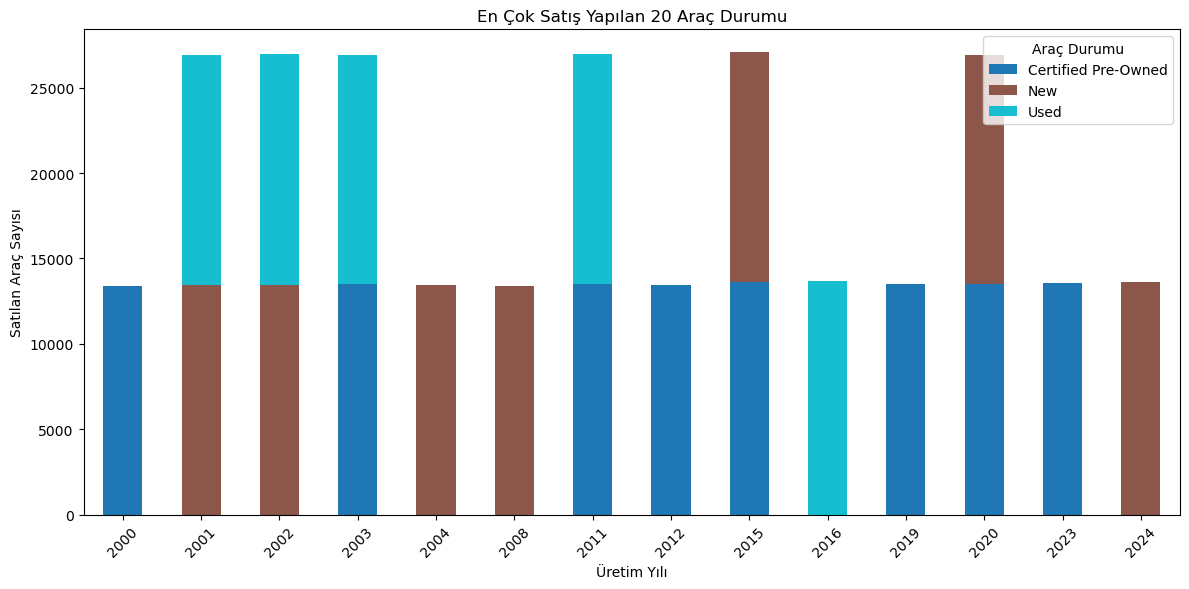

In [95]:
#2001, 2002,2003, 2011, 2015 ve 2020 yılı üretimli araçlarda iki farklı, diğerlerinde tek "condition"a sahip araçların çoğunlukla satıldğı görülmektedir. 

# Verinin pivot_table formatına getirilmesi:
# ChatGPT'den faydalanılmıştır
df_pivot = df_condition.pivot_table(
    index='Üretim_Yılı',
    columns='Condition',
    values='Satılan_Araç',
    aggfunc='sum',
    fill_value=0
)

# Stacked barplot çizimi
df_pivot.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab10')

plt.title("En Çok Satış Yapılan 20 Araç Durumu")
plt.xlabel("Üretim Yılı")
plt.ylabel("Satılan Araç Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Araç Durumu")
plt.show()

In [97]:
# Araçların üretim yıllarına göre en çok araç satılan 20 ülke
df_country = conn.execute("""SELECT
                EXTRACT(YEAR FROM Year) AS Üretim_Yılı,
                Country,
                COUNT(Country) AS Satılan_Araç
                FROM cars
                GROUP BY Year, Country
                ORDER BY COUNT(Country) DESC
                LIMIT 20
                """).fetchdf()
df_country

,Üretim_Yılı,Country,Satılan_Araç
0,2011,Italy,4165
1,2006,USA,4161
2,2001,Germany,4144
3,2016,Canada,4127
4,2015,Japan,4123
5,2001,Australia,4105
6,2024,USA,4104
7,2005,Japan,4104
8,2011,Australia,4097
9,2020,Mexico,4094


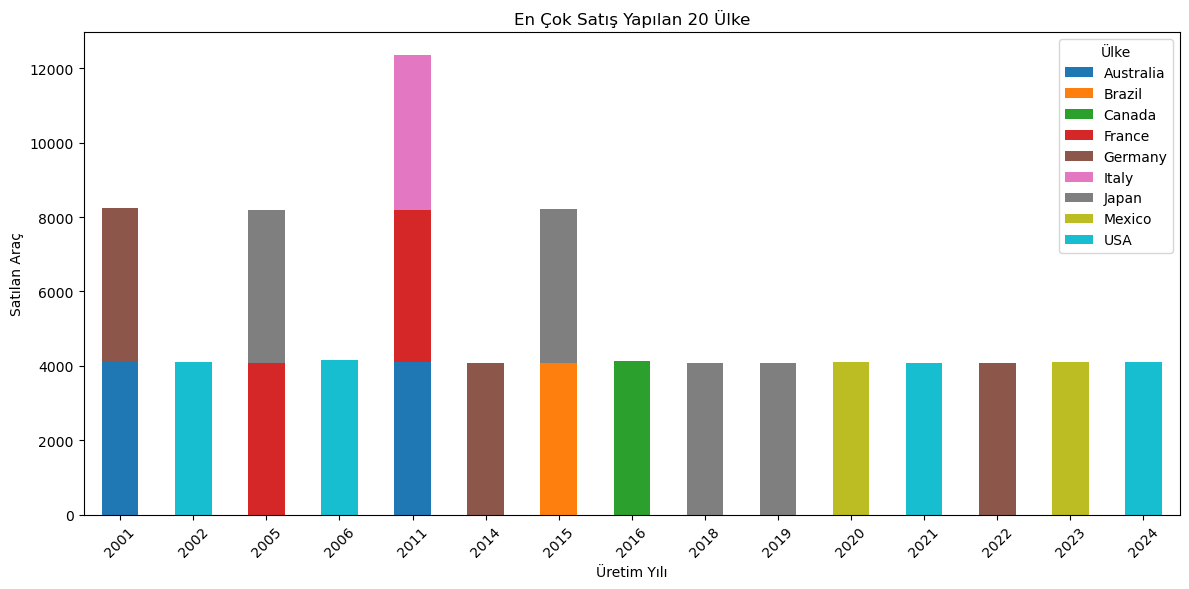

In [98]:
# 2011 yılı üretimi araçların üç; 2001, 2005 ve 2015 yılı üretimi araçların iki, diğer yıl üretim araçların tek bir ülkede en fazla satıldığı görülmektedir.

# Verinin pivot_table formatına getirilmesi:
# ChatGPT'den faydalanılmıştır
df_pivot = df_country.pivot_table(
    index='Üretim_Yılı',
    columns='Country',
    values='Satılan_Araç',
    aggfunc='sum',
    fill_value=0
)

# Stacked barplot çizimi
df_pivot.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab10')

plt.title("En Çok Satış Yapılan 20 Ülke")
plt.xlabel("Üretim Yılı")
plt.ylabel("Satılan Araç")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Ülke")
plt.show()

In [105]:
# Üretim yıllarına göre en çok satılan ilk 3 marka araç (Window Function):
# ChatGPT'den faydalanılmıştır
conn.execute("""SELECT
                EXTRACT(YEAR FROM Year) AS Üretim_Yılı,
                Brand,
                COUNT(*) AS Satılan_Marka_Sayısı,
                RANK() OVER (PARTITION BY Year ORDER BY COUNT(*) DESC) AS Sira
                FROM cars
                GROUP BY Year, Brand
                QUALIFY Sira <= 3
                ORDER BY Üretim_Yılı, Sira
                """).fetchdf()

# COUNT(*) → o yıl o markadan kaç araç var.

# RANK() OVER (PARTITION BY Year ORDER BY COUNT(*) DESC) → her yıl için markaları sıralar (1, 2, 3 …).

# QUALIFY Sira <= 3 → her yıldan sadece ilk 3’ü getirir.

# ORDER BY Üretim_Yılı, Sira → yıl ve sıralamaya göre düzenler.

,Üretim_Yılı,Brand,Satılan_Marka_Sayısı,Sira
0,2000,Jeep,2309,1
1,2000,Ford,2304,2
2,2000,Subaru,2286,3
3,2001,Land Rover,2339,1
4,2001,Nissan,2312,2
...,...,...,...,...
70,2023,Land Rover,2318,2
71,2023,Chevrolet,2263,3
72,2024,Hyundai,2331,1
73,2024,BMW,2310,2


In [129]:
# Üretim yıllarına göre en çok satılan ilk 3 marka araç (CTE):
# ChatGPT'den faydalanılmıştır
df_top3 = conn.execute("""WITH MarkaYillik AS (
                SELECT 
                Year,
                Brand,
                COUNT(*) AS Arac_Sayisi
                FROM cars
                GROUP BY Year, Brand
                ),
                Top3Marka AS (
                            SELECT 
                            Year,
                            Brand,
                            Arac_Sayisi
                            FROM MarkaYillik m1
                            WHERE (
                                    SELECT COUNT(*)
                                    FROM MarkaYillik m2
                                    WHERE m2.Year = m1.Year
                                          AND m2.Arac_Sayisi > m1.Arac_Sayisi
                                    ) < 3
                            )
                SELECT *
                FROM Top3Marka
                ORDER BY Year, Arac_Sayisi DESC
                """).fetchdf()
df_top3

# MarkaYillik → Her yıl + marka için toplam araç sayısını hesaplar.

# Top3Marka → Her yıl, kendisinden daha fazla araca sahip en fazla 2 marka olmasına izin verir. Böylece ilk 3 seçilir.

,Year,Brand,Arac_Sayisi
0,2000-01-01,Jeep,2309
1,2000-01-01,Ford,2304
2,2000-01-01,Subaru,2286
3,2001-01-01,Land Rover,2339
4,2001-01-01,Nissan,2312
...,...,...,...
70,2023-01-01,Land Rover,2318
71,2023-01-01,Chevrolet,2263
72,2024-01-01,Hyundai,2331
73,2024-01-01,BMW,2310


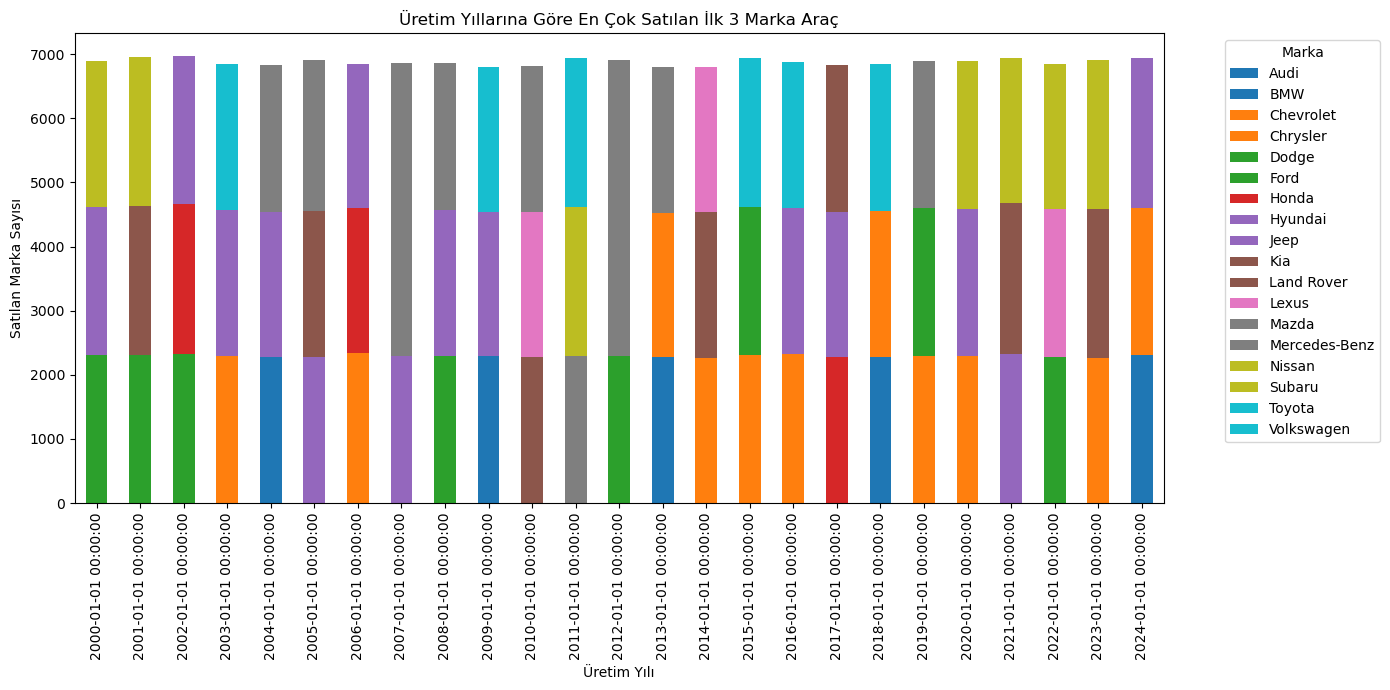

In [130]:
# Son 10 yılda Nissan, Subaru, Toyota, Volkswagen, Chevrolet, Chrysler ve Hyundai marka araçların daha fazla satıldığı görülmektedir. 

df_pivot = df_top3.pivot_table(
    index='Year',
    columns='Brand',
    values='Arac_Sayisi',
    aggfunc='sum',
    fill_value=0
)

df_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(14,7),
    colormap='tab10'  # Renk paleti
)

plt.title("Üretim Yıllarına Göre En Çok Satılan İlk 3 Marka Araç")
plt.xlabel("Üretim Yılı")
plt.ylabel("Satılan Marka Sayısı")
plt.xticks(rotation=90)
plt.legend(title="Marka", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()